In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
import pathlib

In [16]:
COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [2]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES
scaler = preprocessing.StandardScaler().fit(np.vstack([answers.values, answers.values[:, [2, 3, 0, 1]]]))
answers[COORDINATES] = scaler.transform(answers[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [3]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")
votes[COORDINATES] = scaler.transform(votes[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [4]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")
votes_test[COORDINATES] = scaler.transform(votes_test[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [87]:
def find_center(y):
    center_x = (y[0, 2] + y[0, 0]) / 2
    center_y = (y[0, 3] + y[0, 1]) / 2 
    return np.array([center_x, center_y, center_x, center_y])


def scale(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    err_x, err_y = np.random.random(2)  
    
    err_x = 1 + (2 * err_x - 1) * err
    err_y = 1 + (2 * err_y - 1) * err
    
    err = np.array([err_x, err_y, err_x, err_y])
    
    return (x * np.reshape(err, (1, 1, 4)) + np.reshape(center, (1, 1, 4)), 
            y * np.reshape(err, (1, 4)) + np.reshape(center, (1, 4)))
    

def move(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    size_x = (y[0, 2] - y[0, 0]) / 2
    size_y = (y[0, 3] - y[0, 1]) / 2
    
    err_cx, err_cy = np.random.random(2)  
    
    err_cx = (2 * size_x * err_cx - size_x) * err
    err_cy = (2 * size_y * err_cy - size_y) * err
    
    err = np.array([err_cx, err_cy, err_cx, err_cy])
    
    return x + np.reshape(err + center, (1, 1, 4)), y + np.reshape(err + center, (1, 4))
    
def aug_batch(x, y, err=0.1):
    x, y = scale(x, y, err)
    x, y = move(x, y, err)
    return x, y

In [88]:
def yield_batch(data):
    votes, answers = data
    while True:
        item_id = np.random.choice(votes.index, 1)
        forecasts = votes.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        
        x[0] = forecasts.sample(len(forecasts))
        y[0] = answers.loc[item_id]
        yield aug_batch(x, y)

In [6]:
def yield_batch_val(data):
    votes, answers = data
    item_ids = set(votes.index)
    while True:
        for item_id in item_ids:
            forecasts = votes.loc[item_id].set_index("userId")
            x = np.zeros((1, len(forecasts), 4),)
            y = np.zeros((1, 4))

            x[0] = forecasts
            y[0] = answers.loc[item_id]
            yield x, y

In [38]:
def yield_batch_test(data):
    item_ids = data.index.unique()
    for item_id in item_ids:
        forecasts = data.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        x[0] = forecasts
        yield x

In [8]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [9]:
def make_model(filters):
    K.clear_session()
    
    y = x = layers.Input(shape=(None, 4))
    
    mul = 4
    y = layers.Bidirectional(layers.LSTM(
        units=filters * mul,
        return_sequences=True
    ))(y)
    y = layers.Bidirectional(layers.LSTM(
        units=filters * mul,
        return_sequences=False
    ))(y)
    
    y = layers.Dense(
        units=filters * 4,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [90]:
def train_model(data_train, data_val, units, cut_iou=0.53, epochs=100):
    lr = 0.001
    
    model = make_model(units)  
    model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss="mae",
                      metrics=[intersection_over_union]
        )
    rez = model.fit_generator(
            yield_batch(data_train),
            steps_per_epoch=1000,
            epochs=epochs,
            callbacks=[callbacks.EarlyStopping(monitor='val_intersection_over_union', patience=0, verbose=10)],
            validation_data=yield_batch_val(data_val),
            validation_steps=len(data_val[1].index)
        )
    while min(rez.history["val_loss"]) > -cut_iou:
        model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss=intersection_over_union,
                      metrics=None
        )
        cb = [
            callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
            callbacks.EarlyStopping(monitor='val_loss', patience=epochs // 10, min_delta=0.0001, verbose=10),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
        ]
        rez = model.fit_generator(
            yield_batch(data_train),
            steps_per_epoch=1000,
            epochs=epochs,
            callbacks=cb,
            validation_data=yield_batch_val(data_val),
            validation_steps=len(data_val[1].index)
        )
    
    model = models.load_model("../processed/model.h5", custom_objects={"intersection_over_union": intersection_over_union})
    
    return rez, model

In [94]:
FOLDS = 10

def train_oof(train_set, test_set, units=16):
    x_train, y_train = train_set
    x_test = test_set

    y_oof = pd.DataFrame(0, index=y_train.index, columns=COORDINATES)
    y_pred = pd.DataFrame(0, index=x_test.index.unique(), columns=COORDINATES)
    scores = []
    folds = model_selection.KFold(n_splits=FOLDS, shuffle=True)
    
    for n, (index_train, index_valid) in enumerate(folds.split(y_train), 1):
        print(f"\nFold - {n} / {FOLDS}")
        
        ids_train = y_train.index[index_train]
        ids_valid = y_train.index[index_valid]
        
        data_train = (x_train.loc[ids_train], y_train.loc[ids_train])
        data_val = (x_train.loc[ids_valid], y_train.loc[ids_valid])
        
        rez, model = train_model(data_train, data_val, units)
        
        pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))
        scores.append(min(rez.history["val_loss"]))
        
        feat = yield_batch_test(data_val[0])
        df = model.predict_generator(feat, steps=len(data_val[0].index.unique()))
        df = scaler.inverse_transform(df)
        y_oof.loc[ids_valid] = df
        
        feat = yield_batch_test(x_test)
        df = model.predict_generator(feat, steps=len(x_test.index.unique()))
        df = scaler.inverse_transform(df)
        y_pred += df / FOLDS

    print(f"IOU на кроссвалидации: " + str(-np.round(sorted(scores), 5)))
    print(f"IOU среднее: {-np.mean(scores):0.5f} +/- {np.std(scores):0.5f}")

    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    y_oof.to_csv(path / f"oof-{-np.mean(scores):0.5f}.csv", header=False)
    y_pred.to_csv(path / f"sub-{-np.mean(scores):0.5f}.csv", header=False)


Fold - 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         35328     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        


1000/1000 [==============================] - 14s 14ms/step - loss: -0.5972 - val_loss: -0.5451

Epoch 00036: val_loss improved from -0.54507 to -0.54509, saving model to ../processed/model.h5

Epoch 00036: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 37/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5952 - val_loss: -0.5467

Epoch 00037: val_loss improved from -0.54509 to -0.54669, saving model to ../processed/model.h5
Epoch 38/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6048 - val_loss: -0.5457

Epoch 00038: val_loss did not improve from -0.54669
Epoch 39/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6017 - val_loss: -0.5447

Epoch 00039: val_loss did not improve from -0.54669
Epoch 40/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5946 - val_loss: -0.5451

Epoch 00040: val_loss did not improve from -0.54669

Epoch 00040: ReduceLROnPlateau reducin

1000/1000 [==============================] - 13s 13ms/step - loss: -0.5599 - val_loss: -0.5667

Epoch 00023: val_loss improved from -0.56643 to -0.56671, saving model to ../processed/model.h5
Epoch 24/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5545 - val_loss: -0.5626

Epoch 00024: val_loss did not improve from -0.56671
Epoch 25/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5638 - val_loss: -0.5422

Epoch 00025: val_loss did not improve from -0.56671
Epoch 26/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5554 - val_loss: -0.5445

Epoch 00026: val_loss did not improve from -0.56671

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 27/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5591 - val_loss: -0.5697

Epoch 00027: val_loss improved from -0.56671 to -0.56972, saving model to ../processed/model.h5
Epoch 28/100
1000/1000 [===============

1000/1000 [==============================] - 13s 13ms/step - loss: -0.5206 - val_loss: -0.4921

Epoch 00013: val_loss did not improve from -0.52203
Epoch 14/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5233 - val_loss: -0.5188

Epoch 00014: val_loss did not improve from -0.52203

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5433 - val_loss: -0.5246

Epoch 00015: val_loss improved from -0.52203 to -0.52461, saving model to ../processed/model.h5
Epoch 16/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5448 - val_loss: -0.5303

Epoch 00016: val_loss improved from -0.52461 to -0.53033, saving model to ../processed/model.h5
Epoch 17/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5366 - val_loss: -0.5306

Epoch 00017: val_loss improved from -0.53033 to -0.53061, saving model to ../processed/mode

Epoch 1/100
1000/1000 [==============================] - 15s 15ms/step - loss: 0.3062 - intersection_over_union: -0.3489 - val_loss: 0.2316 - val_intersection_over_union: -0.4437
Epoch 2/100
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2241 - intersection_over_union: -0.4492 - val_loss: 0.2166 - val_intersection_over_union: -0.4478
Epoch 3/100
1000/1000 [==============================] - 14s 14ms/step - loss: 0.2145 - intersection_over_union: -0.4586 - val_loss: 0.2402 - val_intersection_over_union: -0.4130
Epoch 00003: early stopping
Epoch 1/100
1000/1000 [==============================] - 17s 17ms/step - loss: -0.4523 - val_loss: -0.4615

Epoch 00001: val_loss improved from inf to -0.46147, saving model to ../processed/model.h5
Epoch 2/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.4501 - val_loss: -0.4656

Epoch 00002: val_loss improved from -0.46147 to -0.46561, saving model to ../processed/model.h5
Epoch 3/100
1000/1000 [=========

1000/1000 [==============================] - 13s 13ms/step - loss: -0.6101 - val_loss: -0.5373

Epoch 00042: val_loss did not improve from -0.53978

Epoch 00042: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 43/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5980 - val_loss: -0.5372

Epoch 00043: val_loss did not improve from -0.53978
Epoch 44/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6068 - val_loss: -0.5360

Epoch 00044: val_loss did not improve from -0.53978
Epoch 45/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6041 - val_loss: -0.5369

Epoch 00045: val_loss did not improve from -0.53978

Epoch 00045: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 46/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.6044 - val_loss: -0.5370

Epoch 00046: val_loss did not improve from -0.53978
Epoch 47/100
1000/1000 [======================

1000/1000 [==============================] - 14s 14ms/step - loss: -0.5746 - val_loss: -0.5681

Epoch 00025: val_loss did not improve from -0.56869
Epoch 26/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5705 - val_loss: -0.5648

Epoch 00026: val_loss did not improve from -0.56869
Epoch 27/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5755 - val_loss: -0.5634

Epoch 00027: val_loss did not improve from -0.56869

Epoch 00027: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 28/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5902 - val_loss: -0.5581

Epoch 00028: val_loss did not improve from -0.56869
Epoch 29/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5844 - val_loss: -0.5631

Epoch 00029: val_loss did not improve from -0.56869
Epoch 30/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5816 - val_loss: -0.5640

Epoch 00030: val_lo


Epoch 00024: val_loss did not improve from -0.56137
Epoch 25/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5838 - val_loss: -0.5578

Epoch 00025: val_loss did not improve from -0.56137
Epoch 26/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5811 - val_loss: -0.5563

Epoch 00026: val_loss did not improve from -0.56137

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 27/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5925 - val_loss: -0.5601

Epoch 00027: val_loss did not improve from -0.56137
Epoch 28/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5882 - val_loss: -0.5599

Epoch 00028: val_loss did not improve from -0.56137
Epoch 29/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5927 - val_loss: -0.5600

Epoch 00029: val_loss did not improve from -0.56137

Epoch 00029: ReduceLROnPlateau reducing learning rate to 7.

1000/1000 [==============================] - 13s 13ms/step - loss: -0.5844 - val_loss: -0.5653

Epoch 00026: val_loss improved from -0.56316 to -0.56533, saving model to ../processed/model.h5
Epoch 27/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5741 - val_loss: -0.5680

Epoch 00027: val_loss improved from -0.56533 to -0.56795, saving model to ../processed/model.h5
Epoch 28/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5787 - val_loss: -0.5632

Epoch 00028: val_loss did not improve from -0.56795
Epoch 29/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5817 - val_loss: -0.5640

Epoch 00029: val_loss did not improve from -0.56795
Epoch 30/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5742 - val_loss: -0.5598

Epoch 00030: val_loss did not improve from -0.56795

Epoch 00030: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 31/100
1000/1000 [===============

1000/1000 [==============================] - 13s 13ms/step - loss: -0.5322 - val_loss: -0.5626

Epoch 00014: val_loss improved from -0.54963 to -0.56256, saving model to ../processed/model.h5
Epoch 15/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5412 - val_loss: -0.5467

Epoch 00015: val_loss did not improve from -0.56256
Epoch 16/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5358 - val_loss: -0.5475

Epoch 00016: val_loss did not improve from -0.56256
Epoch 17/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5485 - val_loss: -0.5489

Epoch 00017: val_loss did not improve from -0.56256

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 18/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5566 - val_loss: -0.5415

Epoch 00018: val_loss did not improve from -0.56256
Epoch 19/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.

1000/1000 [==============================] - 13s 13ms/step - loss: -0.5423 - val_loss: -0.4842

Epoch 00025: val_loss did not improve from -0.50152

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 26/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5496 - val_loss: -0.5052

Epoch 00026: val_loss improved from -0.50152 to -0.50522, saving model to ../processed/model.h5
Epoch 27/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5642 - val_loss: -0.4973

Epoch 00027: val_loss did not improve from -0.50522
Epoch 28/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5662 - val_loss: -0.4952

Epoch 00028: val_loss did not improve from -0.50522
Epoch 29/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5616 - val_loss: -0.5114

Epoch 00029: val_loss improved from -0.50522 to -0.51136, saving model to ../processed/model.h5
Epoch 30/100
1000/1000 [===============

1000/1000 [==============================] - 14s 14ms/step - loss: -0.5506 - val_loss: -0.5059

Epoch 00009: val_loss improved from -0.48541 to -0.50590, saving model to ../processed/model.h5
Epoch 10/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5524 - val_loss: -0.4998

Epoch 00010: val_loss did not improve from -0.50590
Epoch 11/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5490 - val_loss: -0.4898

Epoch 00011: val_loss did not improve from -0.50590
Epoch 12/100
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5482 - val_loss: -0.4912

Epoch 00012: val_loss did not improve from -0.50590

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5766 - val_loss: -0.5151

Epoch 00013: val_loss improved from -0.50590 to -0.51513, saving model to ../processed/model.h5
Epoch 14/100
1000/1000 [===============

1000/1000 [==============================] - 14s 14ms/step - loss: -0.6146 - val_loss: -0.5381

Epoch 00052: val_loss did not improve from -0.53930
Epoch 53/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6197 - val_loss: -0.5372

Epoch 00053: val_loss did not improve from -0.53930
Epoch 54/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6201 - val_loss: -0.5392

Epoch 00054: val_loss did not improve from -0.53930

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 55/100
1000/1000 [==============================] - 15s 15ms/step - loss: -0.6215 - val_loss: -0.5389

Epoch 00055: val_loss did not improve from -0.53930
Epoch 56/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6277 - val_loss: -0.5378

Epoch 00056: val_loss did not improve from -0.53930
Epoch 57/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.6215 - val_loss: -0.5379

Epoch 00057: val_

1000/1000 [==============================] - 14s 14ms/step - loss: -0.5654 - val_loss: -0.5547

Epoch 00025: val_loss did not improve from -0.55858
Epoch 26/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5688 - val_loss: -0.5453

Epoch 00026: val_loss did not improve from -0.55858

Epoch 00026: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 27/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5793 - val_loss: -0.5590

Epoch 00027: val_loss improved from -0.55858 to -0.55898, saving model to ../processed/model.h5
Epoch 28/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5774 - val_loss: -0.5519

Epoch 00028: val_loss did not improve from -0.55898
Epoch 29/100
1000/1000 [==============================] - 14s 14ms/step - loss: -0.5771 - val_loss: -0.5616

Epoch 00029: val_loss improved from -0.55898 to -0.56157, saving model to ../processed/model.h5
Epoch 30/100
1000/1000 [================

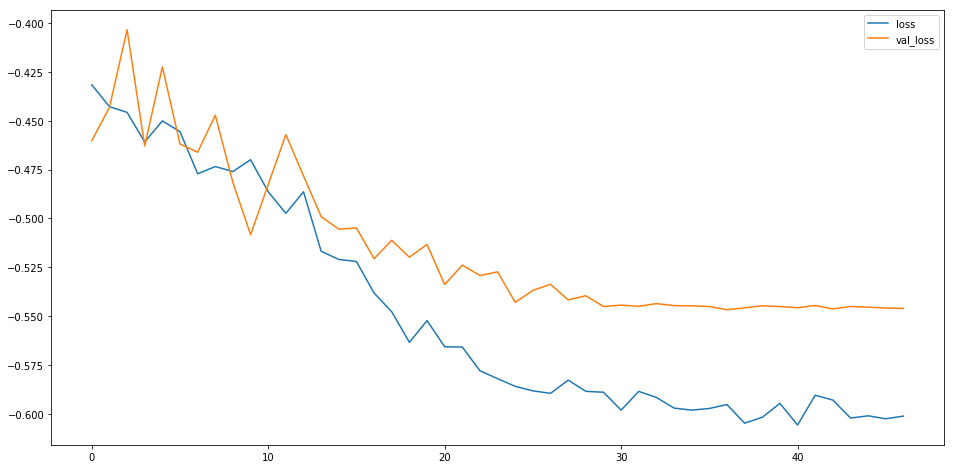

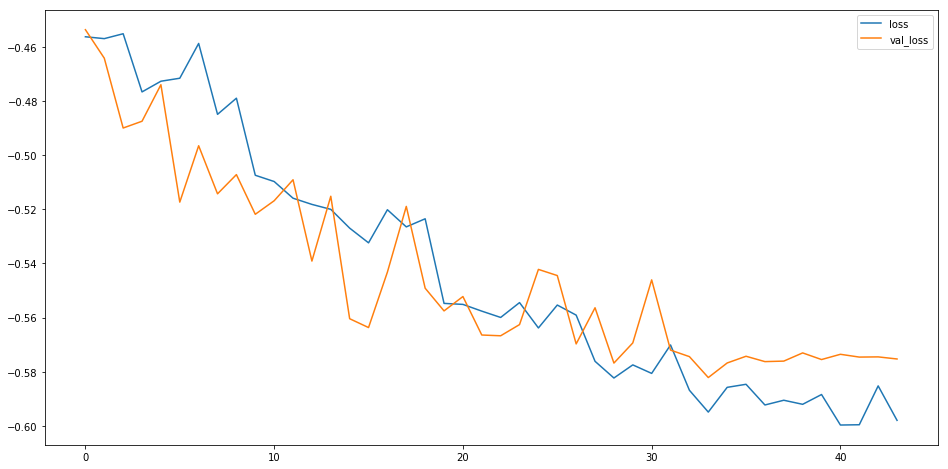

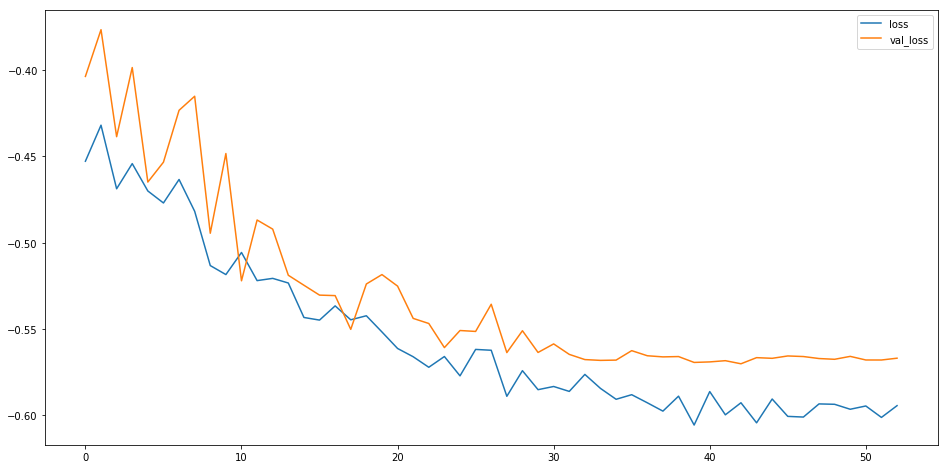

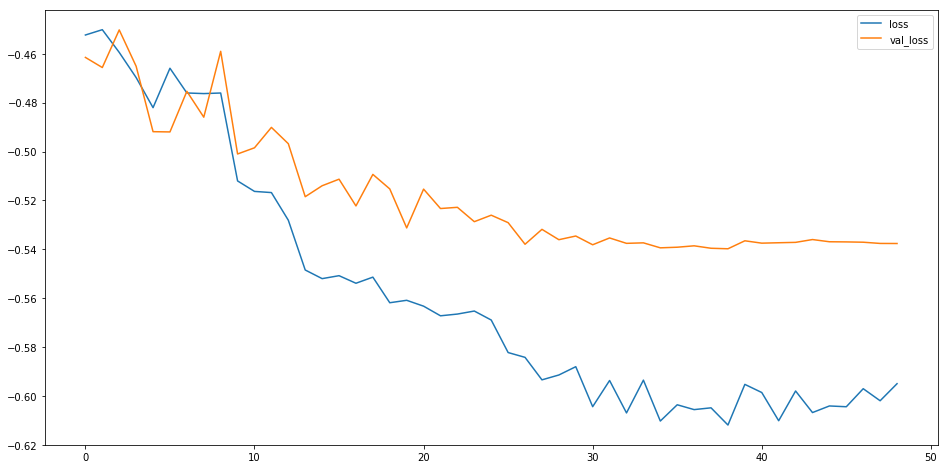

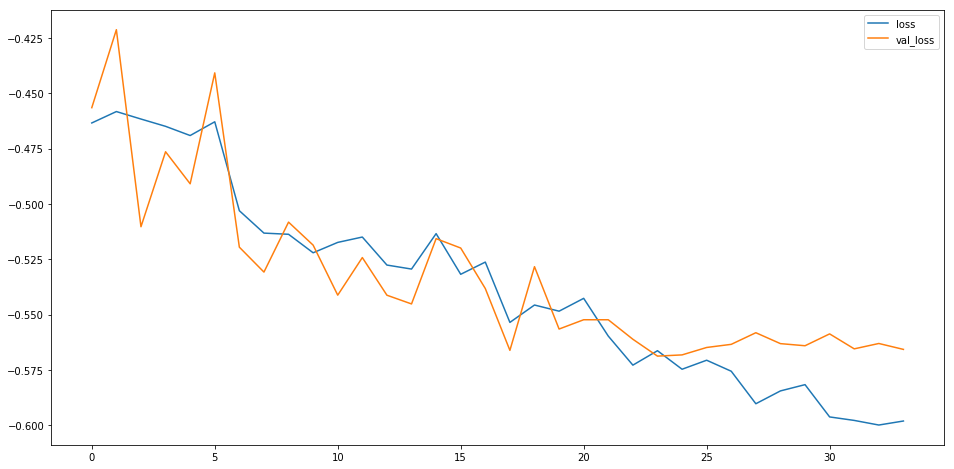

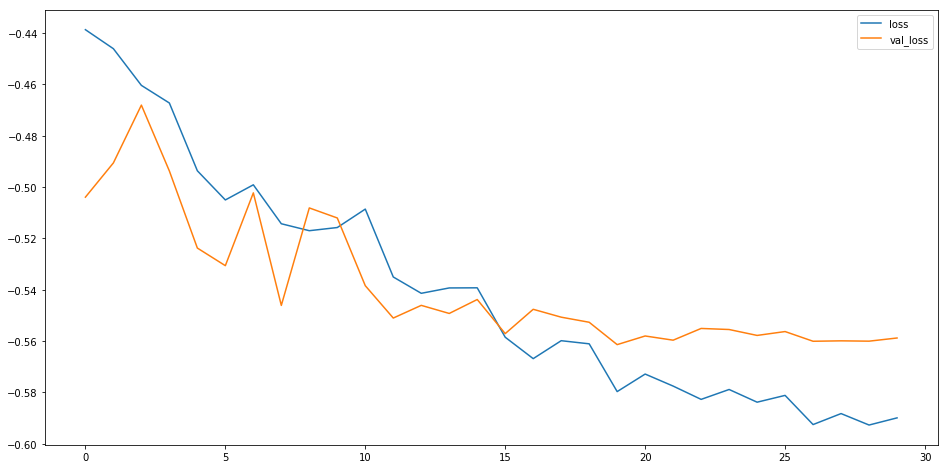

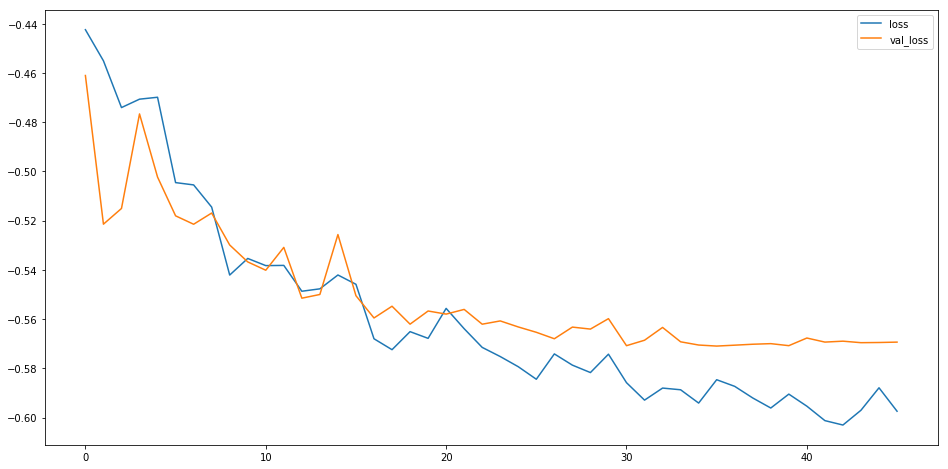

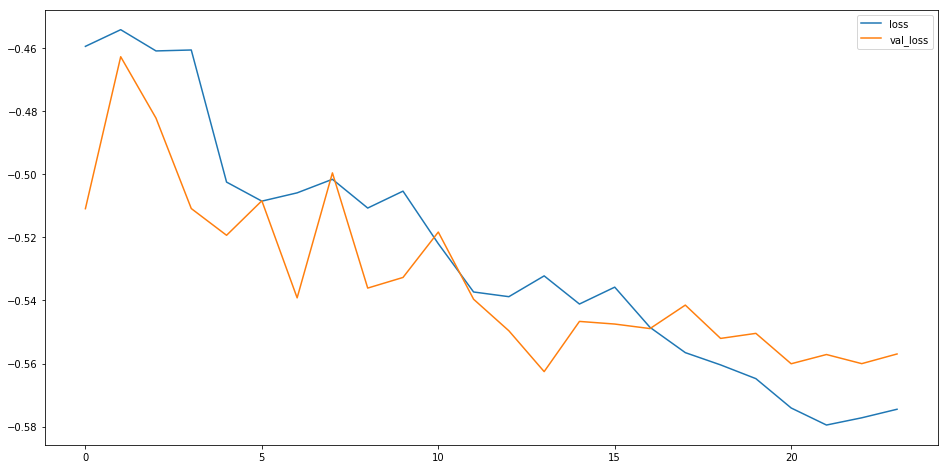

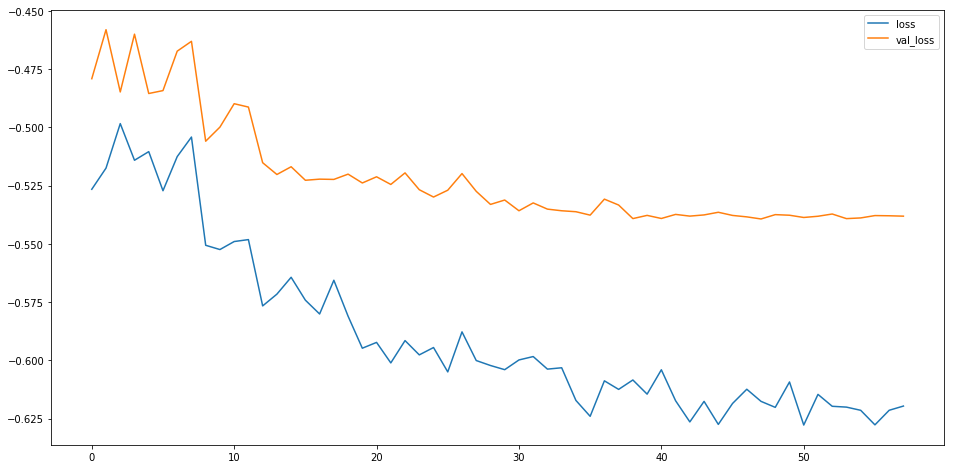

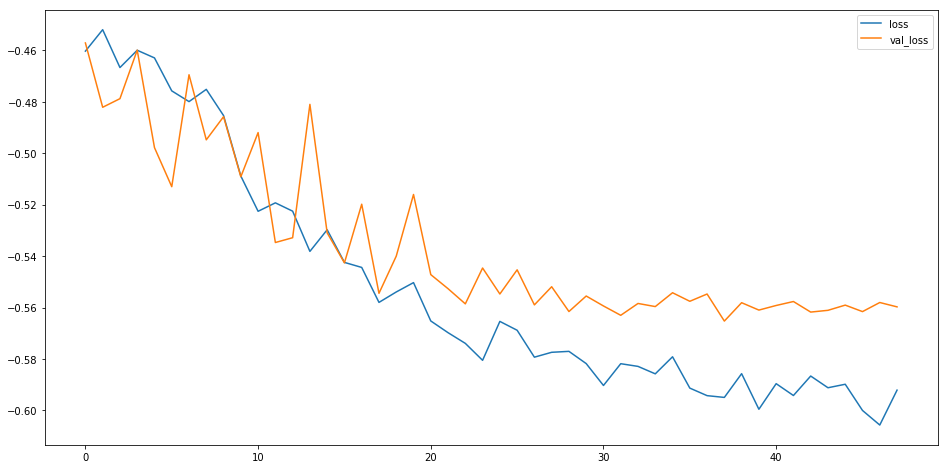

In [93]:
train_oof((votes, answers), votes_test)